In [2]:
import os
import glob
import numpy as np
import xarray as xr
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyrsimg import readTiff, imgShow


In [5]:
dir_save_pixc = 'data/jinsha_river/pixc'
path_jinsha_vec = 'data/jinsha_river/jinsha_vector.gpkg'
path_rsimg = 'data/rsimg/jinsha_s2_20240302_wgs84.tif'
path_jinsha_centerline_vec = 'data/jinsha_river/jinsha_sword_reaches_v16.gpkg'


#### 1. Check data

In [4]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_save_pixc, file) for file in os.listdir(dir_save_pixc) if 'PIXC_' in file and '.nc' in file]
paths_file = sorted(paths_file)
print(paths_file[0])
pixc_nc = xr.open_dataset(paths_file[0], group='pixel_cloud')
pixc_nc


data/jinsha_river/pixc/SWOT_L2_HR_PIXC_009_383_202R_20240117T194047_20240117T194058_PGC0_01.nc


<xarray.Dataset> Size: 865MB
Dimensions:                                (points: 3131980, complex_depth: 2,
                                            num_pixc_lines: 3286)
Coordinates:
    latitude                               (points) float64 25MB ...
    longitude                              (points) float64 25MB ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 25MB ...
    range_index                            (points) float64 25MB ...
    interferogram                          (points, complex_depth) float32 25MB ...
    power_plus_y                           (points) float32 13MB ...
    power_minus_y                          (points) float32 13MB ...
    coherent_power                         (points) float32 13MB ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB ...
    data_window_first_valid                (num_pixc_lines) float64 26kB ...
    data_window_last_valid                 (num_pixc_lines) float64 26kB ...
    data_window_first_cross_track          (num_pixc_lines) float32 13kB ...
    data_window_last_cross_track           (num_pixc_lines) float32 13kB ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3286
    interferogram_size_range:    6395
    looks_to_efflooks:           1.5546233047434288
    num_azimuth_looks:           7.0
    azimuth_offset:              3

In [7]:
rsimg_io = readTiff(path_rsimg)
## read water body vector file of the river.
jinsha_gpd = gpd.read_file(path_jinsha_vec)
jinsha_gpd
## read river centerline.
jinsha_centerline_gpd = gpd.read_file(path_jinsha_centerline_vec)
jinsha_centerline_gpd.head()



,x,y,reach_id,reach_len,n_nodes,wse,wse_var,width,width_var,facc,...,n_rch_dn,rch_id_up,rch_id_dn,swot_orbit,swot_obs,type,river_name,edit_flag,trib_flag,geometry
0,100.067262,27.040321,43499300101,18047.262655,90,1808.099976,0.057228,192.0,1218.938875,214776.753850,...,1,43499300111,43499300091,383 424,2,1,Jinsha River,NaN,0,"LINESTRING (100.05432 27.11296, 100.05438 27.1..."
1,100.015912,26.908294,43499300111,19321.613073,97,1808.099976,1.535153,258.0,11675.897623,214034.512051,...,1,43499300121,43499300101,383,1,1,Jinsha River,NaN,0,"LINESTRING (100.05774 26.96858, 100.05762 26.9..."
2,99.951471,26.963181,43499300121,19294.704374,96,1815.700073,11.623906,248.0,15528.231713,213252.221234,...,1,43499300131,43499300111,383,1,1,Jinsha River,NaN,0,"LINESTRING (99.96419 26.89315, 99.96413 26.893..."
3,99.868713,27.096391,43499300131,19275.847561,96,1833.650024,29.321965,256.0,10277.059439,212499.299697,...,1,43499300141,43499300121,383 424,2,1,Jinsha River,NaN,0,"LINESTRING (99.9217 27.03264, 99.92165 27.0329..."


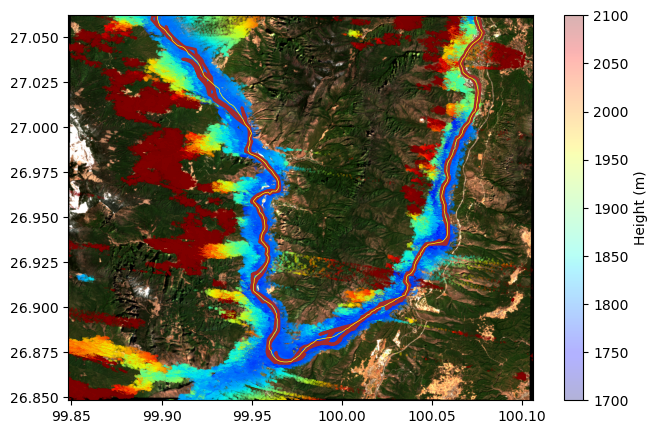

In [11]:
# mask to get good water pixels
# mask = np.where(np.logical_and(pixc_nc.classification > 2, pixc_nc.geolocation_qual <= 4096))
# print(mask[0].shape)
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height, s=0.1, cmap='jet', alpha=0.3)
jinsha_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
jinsha_centerline_gpd.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=0.5)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
plt.clim((1700, 2100))
plt.colorbar().set_label('Height (m)')



#### 2. Select pixel cloud data of the given lake region.

In [13]:
lat = pixc_nc['latitude'].values
lon = pixc_nc['longitude'].values
heights = pixc_nc['height'].values
points = list(zip(lon, lat))
points = [Point(point) for point in points]


In [15]:
mask_vec = jinsha_gpd.geometry[0].contains(np.array(points))
lon_vec = np.ma.masked_array(lon, mask=~mask_vec, fill_value=np.nan)
lat_vec = np.ma.masked_array(lat, mask=~mask_vec, fill_value=np.nan)
heights_vec = np.ma.masked_array(heights, mask=~mask_vec, fill_value=np.nan)


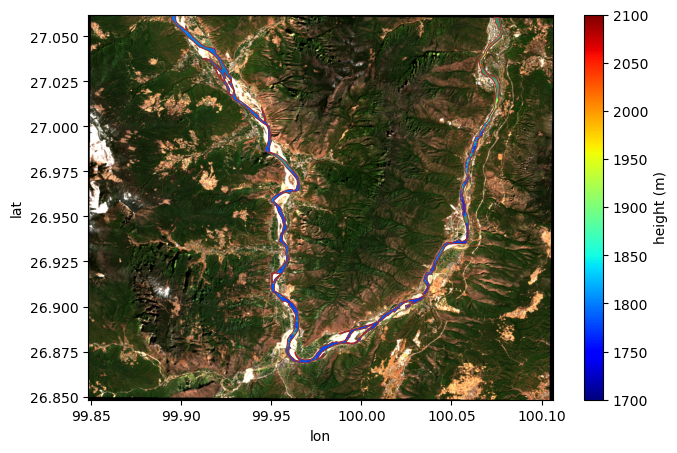

In [33]:
crs='EPSG:4326'
fig, ax = plt.subplots(figsize=(8,5))
scat = ax.scatter(x=lon_vec[~lon_vec.mask], y=lat_vec[~lat_vec.mask], \
                  c=heights_vec[~heights_vec.mask], s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
jinsha_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=0.7)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon'); ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')


(26.86, 27.0)

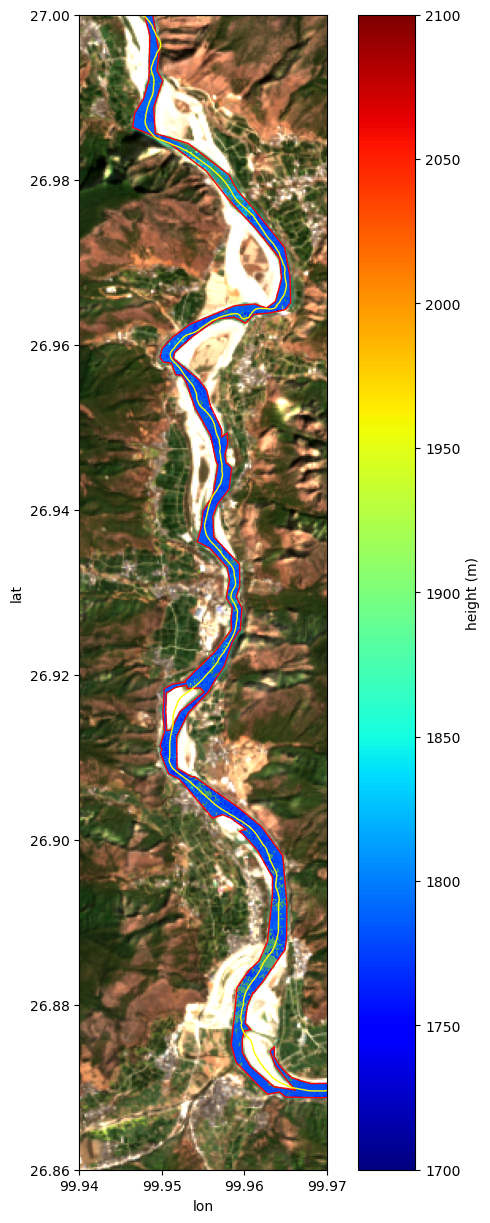

In [19]:
crs='EPSG:4326'
fig, ax = plt.subplots(figsize=(8,15))
scat = ax.scatter(x=lon_vec[~lon_vec.mask], y=lat_vec[~lat_vec.mask], \
                  c=heights_vec[~heights_vec.mask], s=2, edgecolor='none', cmap='jet', clim=(1700, 2100))
jinsha_gpd.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
jinsha_centerline_gpd.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=1)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon'); ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')
# ax.set_xlim([100.05, 100.09])
# ax.set_ylim([27, 27.05])
ax.set_xlim([99.94, 99.97])
ax.set_ylim([26.86, 27.0])
